# Tracking iceberg in Ross Sea in 2017-2020

- Created by YoungHyun Koo (kooala317@gmail.com, younghyun.koo@my.utsa.edu)
- Center for Advanced Measurements in Extreme Environments, University of Texas at San Antonio (UTSA)
- Last updated: 04/08/2021

I found an iceberg floating in Ross Sea. This iceberg started its journey in 2017 from the Amundsen Sea, moved to the Ross Sea, and disappeared in April 2020 in the northern Ross Sea. This tool is made for tracking this iceberg by using Sentinel-1 images through Google Earth Engine (GEE) platform.


In [1]:
## Import required packages =======================================
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import geopandas
import h5py

## Initialize GEE
Next, you will visualize the Sentinel-1 SAR image in GEE.

You will use Python API for GEE. Make sure that "ee" module is installed.
* Refer to this link: https://developers.google.com/earth-engine/python_install

In [15]:
# Import package for GEE
import ee
import folium
ee.Authenticate()
ee.Initialize()


Enter verification code:  4/1AY0e-g49DCUY7QzdNWyFhnfzXJwdDWOl1-P23jmEegCW4iVGKPgmyaHq5n4



Successfully saved authorization token.


In [19]:
# Enter your Google account (ID)
name = input("Enter your Google account (ID): ")

Enter your Google account (ID):  your_ID


Now let's load the Sentinel-1 by using GEE Python API.

## Tracking for Phase 1 (2017/05/01 - 2018/03/18)

- Make sure you have your own reference digitized iceberg in your GEE asset (e.g. iceberg_20170501)
- Manual digitizing in GEE JavaScript code editor: https://code.earthengine.google.com/e0f880934609b81f159913378a435be8

105959579.20889114


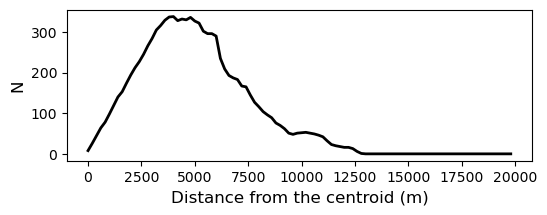

In [9]:
# Reference iceberg distribution
reference = ee.FeatureCollection('users/{0}/iceberg_20170501'.format(name))
centroid = reference.geometry().centroid(10).getInfo()['coordinates']

band = ["HH", "angle"]  # intersted band
    
# Load Sentinel-1 images (image collection)
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate('2017-05-01', '2017-05-02')\
.filterBounds(reference)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

img = S1A.select(band).mean().clip(reference) # clip image into ROI

scale = 200
max_pix = 20000

cover = img.select('HH').clip(reference).multiply(0).add(1)
cover = cover.addBands(ee.Image.pixelLonLat())
# coordinates = cover.reduceRegion(ee.Reducer.mean(), reference, scale = 200, maxPixels = 1e20).getInfo()

sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);

# Compute the cumulative cost to traverse the land cover.
cumulativeCost = cover.select('HH').cumulativeCost(
    source = sources,
    maxDistance = 30000,
    geodeticDistance = True
).clip(reference)

hist1 = {}

fig = plt.subplots(figsize = (6, 2), dpi = 100)
result = cumulativeCost.reduceRegion(ee.Reducer.toList(), reference, scale = 200, maxPixels = 1e20);
A = result.getInfo()['cumulative_cost'] # 'cumulative_cost' 'constant'
hist1['reference'] = np.histogram(A, int(max_pix/scale), [0, max_pix])
area0 = reference.geometry().area(10).getInfo()
plt.plot(hist1['reference'][1][:-1], hist1['reference'][0], color = "k", linewidth = 2)
plt.xlabel("Distance from the centroid (m)", fontsize = 12)
plt.ylabel("N", fontsize = 12)

reference.getInfo()['features'][0]
reference.geometry().centroid(10).getInfo()
print(area0)

In [ ]:
startdate = '2017-05-01'; enddate = '2017-05-02'
center = [-107.41690984744852,-74.5005208661277]

startdate = '2017-09-02'; enddate = '2017-09-03'
center = [-107.27958074588602,-74.07208464463132]

startdate = '2018-01-02'; enddate = '2018-01-03'
center = [-108.32328191776102,-73.52029519701541]

startdate = '2017-04-09'; enddate = '2017-04-10'
center = [-107.07084051151102,-74.68078035824021]

startdate = '2017-04-16'; enddate = '2017-04-17'
center = [-107.40592351932352,-74.51885947623116]

startdate = '2017-04-27'; enddate = '2017-04-28'
center = [-107.40592351932352,-74.51885947623116]

startdate = '2017-06-18'; enddate = '2017-06-19'
center = [-107.26996770877665,-74.47995646451864]

startdate = '2017-07-22'; enddate = '2017-07-23'
center = [-107.33176580447977,-74.23259146811617]


buf_dist = 25000 # buffer distance to find from the center to find icebergs

map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['red', 'chocolate', 'orange', 'yellow', 'olive', 'lime',
               'green', 'teal', 'cyan', 'blue', 'navy', 'purple']

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# How many days are you testing?
day_range = range(0, 200) # for about year (2019-2018)

vectorscale = 40

fig = plt.subplots(figsize = (10, 6))
# plt.plot(hist0[1][:-1], hist0[0], label = "reference", color = "k", linestyle = "--")

for day in day_range:
    
    month = dt.datetime.strptime(startdate, "%Y-%m-%d").month
    band = ["HH", "angle"]  # intersted band
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(80);
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
        
        # Mapping original image ===================================
        vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0, 'region': ross_sea}
        mapid_seg[startdate] = img.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='S1_{0}'.format(startdate),
        ).add_to(map)
        
        # SNIC image segmentaion
        # https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)
        
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
        
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id')       

#         icebergs = segimage_mean.select('ratio').gt(-0.2).selfMask()
        ratio = snic.select("HH").divide(snic.select("angle"))
        icebergs = ratio.gt(-0.2).selfMask()
        
        # Mapping segmented image ===================================
        vis_seg = {'bands': ["HH"], 'min': -0.5, 'max': -0.2, 'region': ross_sea}
        mapid_segimg = ratio.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_segimg['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='Segimage_{0}'.format(startdate),
        ).add_to(map)        
        
        # Map of segmentations =====================================
        vis_seg = {'color': 'red'}
        seg_tile = segments.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=seg_tile['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name="seg_" + startdate,
        ).add_to(map)
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = area0 * 1.2
        area_min = area0 * 0.8
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        num = target.size().getInfo()
        features = target.getInfo()['features']
        
        print(startdate + " ============================================")
        threshold = 0.70
        
        for k in range(0, num): # if there is a valid iceberg
            
            area = features[k]['properties']['area']
            centroid = features[k]['properties']['centroid']['coordinates']
            polygon = ee.FeatureCollection(ee.Geometry.Polygon(features[k]['geometry']['coordinates'][0]))
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
            covers = snic.select('HH').multiply(0).add(1)
            
            cumCost = covers.cumulativeCost(
                source = sources,
                maxDistance = 30000,
                geodeticDistance = True
            ).clip(polygon)

            result = cumCost.reduceRegion(ee.Reducer.toList(), polygon, scale = 200)
            cumdist = result.getInfo()['cumulative_cost']
            B = np.histogram(cumdist, int(max_pix/scale), [0, max_pix])  
            
            diff = abs(hist1['reference'][0] - B[0])
            similarity = 1-np.sum(diff)/np.sum(hist1['reference'][0])
            
            vis_target = {'color': color_codes[month-1]}
            mapid_target = polygon.getMapId(vis_target) 
            
            # Map of iceberg vectors
            folium.TileLayer(
                tiles=mapid_target['tile_fetcher'].url_format,
                attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
                overlay=True,
                name=startdate + "_" + str(k),
            ).add_to(map)           
            
            print("Feature {0} >>> area: {1} km^2, centroid: [{2}, {3}], similarity: {4}".format(
                k, round(area/1e6,2), round(centroid[0],3), round(centroid[1], 3), round(similarity, 3)
            ))                       
            
            if similarity >= threshold:
                
                ice_area[startdate] = area
                ice_centroid[startdate] = centroid
                hist1[startdate] = B 
                plt.plot(B[1][:-1], B[0], label = startdate + "_" + str(k))
                  
                threshold = similarity
                
                def add_columns(feature):
                    return feature.set({"area": feature.geometry().area(10),
                                        "centroid": feature.geometry().centroid(10),
                                        "similarity": similarity,
                                        "refdate": '2017-05-01'});
                
                polygon2 = polygon.map(add_columns)
                
                task = ee.batch.Export.table.toDrive(
                    collection = polygon2,
                    folder = 'Iceberg_tracking_auto',
                    description = "Iceberg_{0}".format(startdate),
                    fileFormat = 'KML'
                )
                
                task.start()
                
                print("... exporting task for {0}".format(startdate))
                
                center = centroid
                buf_dist = 0
            
            
    if (buf_dist > 250000) or (startdate == "2017-09-01"): # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    startdate = enddate
    enddate = (dt.datetime.strptime(enddate, "%Y-%m-%d") + dt.timedelta(days=1)).strftime("%Y-%m-%d")

# plt.legend()


## Tracking for Phase 2 (2018/03/18 - 2019/02/28)

- Make sure you have your own reference digitized iceberg in your GEE asset (e.g. iceberg_20180914)
- Manual digitizing in GEE JavaScript code editor: https://code.earthengine.google.com/e0f880934609b81f159913378a435be8

94898081.79755262


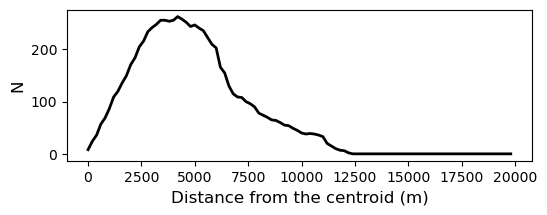

In [10]:
# Reference iceberg distribution
reference = ee.FeatureCollection('users/{0}/iceberg_20180914'.format(name))
centroid = reference.geometry().centroid(10).getInfo()['coordinates']

band = ["HH", "angle"]  # intersted band
    
# Load Sentinel-1 images (image collection)
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate('2018-09-14', '2018-09-15')\
.filterBounds(reference)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

img = S1A.select(band).mean().clip(reference) # clip image into ROI

scale = 200
max_pix = 20000

cover = img.select('HH').clip(reference).multiply(0).add(1)
cover = cover.addBands(ee.Image.pixelLonLat())
# coordinates = cover.reduceRegion(ee.Reducer.mean(), reference, scale = 200, maxPixels = 1e20).getInfo()

sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);

# Compute the cumulative cost to traverse the land cover.
cumulativeCost = cover.select('HH').cumulativeCost(
    source = sources,
    maxDistance = 30000,
    geodeticDistance = True
).clip(reference)

if 'hist2' not in globals():
    hist2 = {}

fig = plt.subplots(figsize = (6, 2), dpi = 100)
result = cumulativeCost.reduceRegion(ee.Reducer.toList(), reference, scale = 200, maxPixels = 1e20);
A = result.getInfo()['cumulative_cost'] # 'cumulative_cost' 'constant'
hist2['reference'] = np.histogram(A, int(max_pix/scale), [0, max_pix])
area0 = reference.geometry().area(10).getInfo()
plt.plot(hist2['reference'][1][:-1], hist2['reference'][0], color = "k", linewidth = 2)
plt.xlabel("Distance from the centroid (m)", fontsize = 12)
plt.ylabel("N", fontsize = 12)

reference.getInfo()['features'][0]
reference.geometry().centroid(10).getInfo()
print(area0)

In [ ]:
startdate = '2018-03-18'; enddate = '2018-03-19'
center = [-108.64188543338602,-72.7881345042331]

startdate = '2018-05-02'; enddate = '2018-05-03'
center = [-112.43216863651102,-72.22008468758618]

startdate = '2018-06-08'; enddate = '2018-06-09'
center = [-112.97049871463602,-72.15959892289469]

startdate = '2018-06-26'; enddate = '2018-06-27'
center = [-114.02518621463602,-72.33046021688021]

startdate = '2018-07-04'; enddate = '2018-07-05'
center = [-115.48636785526102,-72.70994073347087]

startdate = '2018-07-16'; enddate = '2018-07-17'
center = [-114.60746160526102,-72.6707148065568]

startdate = '2018-07-28'; enddate = '2018-07-29'
center = [-115.29960027713602,-72.78163147516548]

startdate = '2018-08-09'; enddate = '2018-08-10'
center = [-116.88163152713602,-72.69033854126403]

startdate = '2018-08-11'; enddate = '2018-08-12'
center = [-117.90885320682352,-72.55251880813104]

startdate = '2018-09-14'; enddate = '2018-09-15'
center = [-123.66568914432352,-71.91565947090466]

startdate = '2018-09-25'; enddate = '2018-09-26'
center = [-124.76981512088602,-72.17810177582666]

startdate = '2018-10-21'; enddate = '2018-10-22'
center = [-126.02225652713602,-72.25862442985495]

startdate = '2018-11-02'; enddate = '2018-11-03'
center = [-127.73932794578221,-72.5164287958811]

startdate = '2019-01-09'; enddate = '2019-01-10'
center = [-135.02005926151102,-73.51561972087731]

startdate = '2019-01-21'; enddate = '2019-01-22'
center = [-136.01981512088602,-73.45628528563523]

startdate = '2019-02-02'; enddate = '2019-02-03'
center = [-136.28903560641777,-73.37814251757015]

startdate = '2019-02-14'; enddate = '2019-02-15'
center = [-136.0098053553598,-73.34004195946177]

startdate = '2019-02-26'; enddate = '2019-02-27'
center = [-137.49795953362585,-73.39886267856943]

startdate = '2019-03-10'; enddate = '2019-03-11'
center = [-139.00284509494816,-73.887777250202]

buf_dist = 25000 # buffer distance to find from the center to find icebergs

map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['red', 'chocolate', 'orange', 'yellow', 'olive', 'lime',
               'green', 'teal', 'cyan', 'blue', 'navy', 'purple']

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# How many days are you testing?
day_range = range(0, 30) # for about year (2019-2018)

vectorscale = 40

features = []
fig = plt.subplots(figsize = (10, 6))
plt.plot(hist2['reference'][1][:-1], hist2['reference'][0], label = "reference", color = "k", linestyle = "--")

for day in day_range:
    
    month = dt.datetime.strptime(startdate, "%Y-%m-%d").month
    band = ["HH", "angle"]  # intersted band
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(100);
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
        
        # Mapping original image ===================================
        vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0, 'region': ross_sea}
        mapid_seg[startdate] = img.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='S1_{0}'.format(startdate),
        ).add_to(map)
        
        # SNIC image segmentaion
        # https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)
        
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
        
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id') 
        

#         icebergs = segimage_mean.select('ratio').gt(-0.2).selfMask()
        ratio = snic.select("HH").divide(snic.select("angle"))
        icebergs = ratio.gt(-0.2).selfMask()
        
        # Mapping segmented image ===================================
        vis_seg = {'bands': ["HH"], 'min': -0.5, 'max': -0.2, 'region': ross_sea}
        mapid_segimg = ratio.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_segimg['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='Segimage_{0}'.format(startdate),
        ).add_to(map)        
        
        # Map of segmentations =====================================
        vis_seg = {'color': 'red'}
        seg_tile = segments.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=seg_tile['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name="seg_" + startdate,
        ).add_to(map)
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = area0 * 1.2
        area_min = area0 * 0.8
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        num = target.size().getInfo()
        features = target.getInfo()['features']
        
        print(startdate + " ============================================")
        threshold = 0.8
        
        for k in range(0, num): # if there is a valid iceberg
            
            area = features[k]['properties']['area']
            centroid = features[k]['properties']['centroid']['coordinates']
            polygon = ee.FeatureCollection(ee.Geometry.Polygon(features[k]['geometry']['coordinates'][0]))
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
            covers = snic.select('HH').multiply(0).add(1)
            
            cumCost = covers.cumulativeCost(
                source = sources,
                maxDistance = 30000,
                geodeticDistance = True
            ).clip(polygon)

            result = cumCost.reduceRegion(ee.Reducer.toList(), polygon, scale = 200)
            cumdist = result.getInfo()['cumulative_cost']
            B = np.histogram(cumdist, int(max_pix/scale), [0, max_pix])  
            
            diff = abs(hist2['reference'][0] - B[0])
            similarity = 1-np.sum(diff)/np.sum(hist2['reference'][0])
            
            vis_target = {'color': color_codes[month-1]}
            mapid_target = polygon.getMapId(vis_target) 
            
            # Map of iceberg vectors
            folium.TileLayer(
                tiles=mapid_target['tile_fetcher'].url_format,
                attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
                overlay=True,
                name=startdate + "_" + str(k),
            ).add_to(map)           
            
            print("Feature {0} >>> area: {1} km^2, centroid: [{2}, {3}], similarity: {4}".format(
                k, round(area/1e6,2), round(centroid[0],3), round(centroid[1], 3), round(similarity, 3)
            ))                       
            
            if similarity >= threshold:
                
                ice_area[startdate] = area
                ice_centroid[startdate] = centroid
                hist2[startdate] = B   
                threshold = similarity
                
                plt.plot(B[1][:-1], B[0], label = startdate + "_" + str(k))
                
                def add_columns(feature):
                    return feature.set({"area": feature.geometry().area(10),
                                        "centroid": feature.geometry().centroid(10),
                                        "similarity": similarity,
                                        "refdate": '2017-05-01'});
                
                polygon2 = polygon.map(add_columns)
                
                task = ee.batch.Export.table.toDrive(
                    collection = polygon2,
                    folder = 'Iceberg_tracking_auto',
                    description = "Iceberg_{0}".format(startdate),
                    fileFormat = 'KML'
                )
                
                task.start()
                
                print("... exporting task for {0}".format(startdate))
                
                center = centroid
                buf_dist = 0
            
            
    if (buf_dist > 250000) or (startdate == "2019-03-23"): # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    startdate = enddate
    enddate = (dt.datetime.strptime(enddate, "%Y-%m-%d") + dt.timedelta(days=1)).strftime("%Y-%m-%d")




## Trcking for Phase 3 (2019/03/25-2019/12/31)

- Make sure you have your own reference digitized iceberg in your GEE asset (e.g. iceberg_20190329)
- Manual digitizing in GEE JavaScript code editor: https://code.earthengine.google.com/e0f880934609b81f159913378a435be8

84246026.47867517


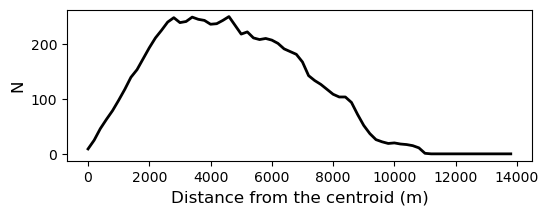

In [6]:
# Reference iceberg distribution
reference = ee.FeatureCollection('users/{0}/iceberg_20190329'.format(name))
centroid = reference.geometry().centroid(10).getInfo()['coordinates']

band = ["HH", "angle"]  # intersted band
    
# Load Sentinel-1 images (image collection)
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate('2019-03-29', '2019-03-30')\
.filterBounds(reference)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

img = S1A.select(band).mean().clip(reference) # clip image into ROI

scale = 200
max_pix = 14000

cover = img.select('HH').clip(reference).multiply(0).add(1)
cover = cover.addBands(ee.Image.pixelLonLat())
# coordinates = cover.reduceRegion(ee.Reducer.mean(), reference, scale = 200, maxPixels = 1e20).getInfo()

sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);

# kernel = ee.Kernel.euclidean(max_pix, "pixels");
# cumulativeCost = sources.distance(kernel, False).clip(reference)
# sources = sources.updateMask(cover);

# Compute the cumulative cost to traverse the land cover.
cumulativeCost = cover.select('HH').cumulativeCost(
    source = sources,
    maxDistance = 30000,
    geodeticDistance = True
).clip(reference)

if 'hist3' not in globals():
    hist3 = {}

fig = plt.subplots(figsize = (6, 2), dpi = 100)
result = cumulativeCost.reduceRegion(ee.Reducer.toList(), reference, scale = 200, maxPixels = 1e20);
A = result.getInfo()['cumulative_cost'] # 'cumulative_cost' 'constant'
hist3['reference'] = np.histogram(A, int(max_pix/scale), [0, max_pix])
area0 = reference.geometry().area(10).getInfo()
plt.plot(hist3['reference'][1][:-1], hist3['reference'][0], color = "k", linewidth = 2)
plt.xlabel("Distance from the centroid (m)", fontsize = 12)
plt.ylabel("N", fontsize = 12)

reference.getInfo()['features'][0]
reference.geometry().centroid(10).getInfo()
print(area0)

In [ ]:
startdate = '2019-03-25'; enddate = '2019-03-26'
center = [-144.196, -74.194]

startdate = '2019-04-22'; enddate = '2019-04-23'
center = [-148.85184637088602,-74.54010574643914]

startdate = '2019-05-29'; enddate = '2019-05-30'
center = [-156.73324255086862,-76.24197557548395]

startdate = '2019-06-25'; enddate = '2019-06-26'
center = [-159.765867433003,-76.20434883050252]

startdate = '2019-12-03'; enddate = '2019-12-04'
center = [-172.02366479657988,-72.03584559268326]

startdate = '2019-12-05'; enddate = '2019-12-06'
center = [-171.99173228647626,-71.98634275272701]

startdate = '2019-12-27'; enddate = '2019-12-28'
center = [-172.27469793338602,-71.92759185065805]

buf_dist = 25000 # buffer distance to find from the center to find icebergs

map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['red', 'chocolate', 'orange', 'yellow', 'olive', 'lime',
               'green', 'teal', 'cyan', 'blue', 'navy', 'purple']

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# How many days are you testing?
day_range = range(0, 6) # for about year (2019-2018)

vectorscale = 40

features = []
fig = plt.subplots(figsize = (10, 6))
plt.plot(hist3['reference'][1][:-1], hist3['reference'][0], label = "reference", color = "k", linestyle = "--")

for day in day_range:
    
    month = dt.datetime.strptime(startdate, "%Y-%m-%d").month
    band = ["HH", "angle"]  # intersted band
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(80);
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
        
        # Mapping original image ===================================
        vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0, 'region': ross_sea}
        mapid_seg[startdate] = img.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='S1_{0}'.format(startdate),
        ).add_to(map)
        
        # SNIC image segmentaion
        # https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)
        
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
        
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id')      

        # icebergs = segimage_mean.select('ratio').gt(-0.2).selfMask()
        ratio = snic.select("HH").divide(snic.select("angle"))
        icebergs = ratio.gt(-0.2).selfMask()
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = area0 * 1.3
        area_min = area0 * 0.7
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        num = target.size().getInfo()
        features = target.getInfo()['features']
        
        print(startdate + " ============================================")
        threshold = 0.70
        
        for k in range(0, num): # if there is a valid iceberg
            
            area = features[k]['properties']['area']
            centroid = features[k]['properties']['centroid']['coordinates']
            polygon = ee.FeatureCollection(ee.Geometry.Polygon(features[k]['geometry']['coordinates'][0]))
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
            covers = snic.select('HH').multiply(0).add(1)
            
            cumCost = covers.cumulativeCost(
                source = sources,
                maxDistance = 30000,
                geodeticDistance = True
            ).clip(polygon)

            result = cumCost.reduceRegion(ee.Reducer.toList(), polygon, scale = 200)
            cumdist = result.getInfo()['cumulative_cost']
            B = np.histogram(cumdist, int(max_pix/scale), [0, max_pix])  
            
            diff = abs(hist3['reference'][0] - B[0])
            similarity = 1-np.sum(diff)/np.sum(hist3['reference'][0])         
            
            print("Feature {0} >>> area: {1} km^2, centroid: [{2}, {3}], similarity: {4}".format(
                k, round(area/1e6,2), round(centroid[0],3), round(centroid[1], 3), round(similarity, 3)
            ))                       
            
            if similarity >= threshold:
                
                ice_area[startdate] = area
                ice_centroid[startdate] = centroid
                hist3[startdate] = B   
                threshold = similarity
                
                plt.plot(B[1][:-1], B[0], label = startdate + "_" + str(k))
                
                def add_columns(feature):
                    return feature.set({"area": feature.geometry().area(10),
                                        "centroid": feature.geometry().centroid(10),
                                        "similarity": similarity,
                                        "refdate": '2017-05-01'});
                
                polygon2 = polygon.map(add_columns)
                
                task = ee.batch.Export.table.toDrive(
                    collection = polygon2,
                    folder = 'Iceberg_tracking_auto',
                    description = "Iceberg_{0}".format(startdate),
                    fileFormat = 'KML'
                )
                
                # task.start()
                
                print("... exporting task for {0}".format(startdate))
                
                center = centroid
                buf_dist = 0
            
            
    if (buf_dist > 250000) or (startdate == "2020-01-01"): # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    startdate = enddate
    enddate = (dt.datetime.strptime(enddate, "%Y-%m-%d") + dt.timedelta(days=1)).strftime("%Y-%m-%d")


## Tracking for Phase4 (2020/01/01 - 2020/03/20)

- Make sure you have your own reference digitized iceberg in your GEE asset (e.g. iceberg_20200117)
- Manual digitizing in GEE JavaScript code editor: https://code.earthengine.google.com/e0f880934609b81f159913378a435be8

76860906.20559217


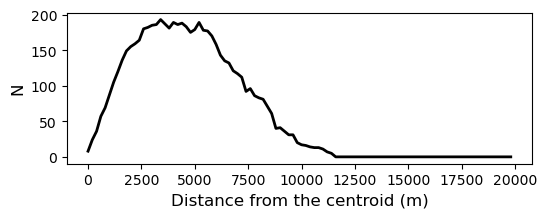

In [13]:
# Reference iceberg distribution
reference = ee.FeatureCollection('users/{0}/iceberg_20200117'.format(name))
centroid = reference.geometry().centroid(10).getInfo()['coordinates']

band = ["HH", "angle"]  # intersted band
    
# Load Sentinel-1 images (image collection)
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate('2020-01-17', '2020-01-18')\
.filterBounds(reference)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

img = S1A.select(band).mean().clip(reference) # clip image into ROI

scale = 200
max_pix = 20000

cover = img.select('HH').clip(reference).multiply(0).add(1)
cover = cover.addBands(ee.Image.pixelLonLat())
# coordinates = cover.reduceRegion(ee.Reducer.mean(), reference, scale = 200, maxPixels = 1e20).getInfo()

sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);

# Compute the cumulative cost to traverse the land cover.
cumulativeCost = cover.select('HH').cumulativeCost(
    source = sources,
    maxDistance = 30000,
    geodeticDistance = True
).clip(reference)

if 'hist4' not in globals():
    hist4 = {}
    
fig = plt.subplots(figsize = (6, 2), dpi = 100)

result = cumulativeCost.reduceRegion(ee.Reducer.toList(), reference, scale = 200, maxPixels = 1e20);
A = result.getInfo()['cumulative_cost'] # 'cumulative_cost' 'constant'
hist4['reference'] = np.histogram(A, int(max_pix/scale), [0, max_pix])
area0 = reference.geometry().area(10).getInfo()
plt.plot(hist4['reference'][1][:-1], hist4['reference'][0], color = "k", linewidth = 2)
plt.xlabel("Distance from the centroid (m)", fontsize = 12)
plt.ylabel("N", fontsize = 12)

reference.getInfo()['features'][0]
reference.geometry().centroid(10).getInfo()
print(area0)

In [ ]:
# startdate = '2019-12-31'; enddate = '2020-01-01'
# center = [-172.73063055057352,-71.76757955308366]

startdate = '2019-12-27'; enddate = '2019-12-28'
center = [-172.27469793338602,-71.92759185065805]

startdate = '2020-01-05'; enddate = '2020-01-06'
center = [-173.14948431033915,-71.81349774032267]

startdate = '2020-01-17'; enddate = '2020-01-18'
center = [-173.5202728845579,-71.79377091890227]

startdate = '2020-03-12'; enddate = '2020-03-13'
center = [-178.5959564783079,-69.9633528367943]

startdate = '2020-03-13'; enddate = '2020-03-14'
center = [-178.7827240564329,-69.9633528367943]

buf_dist = 25000 # buffer distance to find from the center to find icebergs

map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['red', 'chocolate', 'orange', 'yellow', 'olive', 'lime',
               'green', 'teal', 'cyan', 'blue', 'navy', 'purple']

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# How many days are you testing?
day_range = range(0, 1) # for about year (2019-2018)

vectorscale = 40

features = []
fig = plt.subplots(figsize = (10, 6))
plt.plot(hist4['reference'][1][:-1], hist4['reference'][0], label = "reference", color = "k", linestyle = "--")

for day in day_range:
    
    month = dt.datetime.strptime(startdate, "%Y-%m-%d").month
    band = ["HH", "angle"]  # intersted band
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(100);
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
        
        # Mapping original image ===================================
        vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0, 'region': ross_sea}
        mapid_seg[startdate] = img.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='S1_{0}'.format(startdate),
        ).add_to(map)
        
        # SNIC image segmentaion
        # https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)
        
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
        
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id')      

        # icebergs = segimage_mean.select('ratio').gt(-0.2).selfMask()
        ratio = snic.select("HH").divide(snic.select("angle"))
        icebergs = ratio.gt(-0.2).clip(ross_sea).selfMask()
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = area0 * 1.2
        area_min = area0 * 0.8
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        num = target.size().getInfo()
        features = target.getInfo()['features']
        
        print(startdate + " ============================================")
        threshold = 0.70
        
        for k in range(0, num): # if there is a valid iceberg
            
            area = features[k]['properties']['area']
            centroid = features[k]['properties']['centroid']['coordinates']
            polygon = ee.FeatureCollection(ee.Geometry.Polygon(features[k]['geometry']['coordinates'][0]))
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
            covers = snic.select('HH').multiply(0).add(1)
            
            cumCost = covers.cumulativeCost(
                source = sources,
                maxDistance = 30000,
                geodeticDistance = True
            ).clip(polygon)

            result = cumCost.reduceRegion(ee.Reducer.toList(), polygon, scale = 200)
            cumdist = result.getInfo()['cumulative_cost']
            B = np.histogram(cumdist, int(max_pix/scale), [0, max_pix])  
            
            diff = abs(hist4['reference'][0] - B[0])
            similarity = 1-np.sum(diff)/np.sum(hist4['reference'][0])         
            
            print("Feature {0} >>> area: {1} km^2, centroid: [{2}, {3}], similarity: {4}".format(
                k, round(area/1e6,2), round(centroid[0],3), round(centroid[1], 3), round(similarity, 3)
            ))                       
            
            if similarity >= threshold:
                
                ice_area[startdate] = area
                ice_centroid[startdate] = centroid
                hist4[startdate] = B   
                threshold = similarity
                
                plt.plot(B[1][:-1], B[0], label = startdate + "_" + str(k))
                
                def add_columns(feature):
                    return feature.set({"area": feature.geometry().area(10),
                                        "centroid": feature.geometry().centroid(10),
                                        "similarity": similarity,
                                        "refdate": '2017-05-01'});
                
                polygon2 = polygon.map(add_columns)
                
                task = ee.batch.Export.table.toDrive(
                    collection = polygon2,
                    folder = 'Iceberg_tracking_auto',
                    description = "Iceberg_{0}".format(startdate),
                    fileFormat = 'KML'
                )
                
                task.start()
                
                print("... exporting task for {0}".format(startdate))
                
                center = centroid
                buf_dist = 0
            
            
    if (buf_dist > 250000) or (startdate == "2020-03-22"): # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    startdate = enddate
    enddate = (dt.datetime.strptime(enddate, "%Y-%m-%d") + dt.timedelta(days=1)).strftime("%Y-%m-%d")
